In [1]:
# !pip install pydeseq2
# !pip install scanpy
# !pip install gseapy
# !pip install gprofiler-official

### Rationale
In this analysis, I aim to identify genes that are differentially expressed in Glioblastoma Multiforme (GBM) tumors compared to normal tissue. Understanding differential gene expression in GBM may reveal insights into tumor biology, potential biomarkers, or therapeutic targets. I will perform the following series of steps:
 that include data normalization, application of statistical tests to identify significant genes, and visualization of results.

#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import requests, sys
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
import gseapy as gp
from gseapy.plot import gseaplot
import scanpy as sc
from gprofiler import GProfiler

### Processing TCGA DATA for Bulk Rna-seq Analysis
* The Cancer Genome Atlas (TCGA) is a comprehensive and coordinated effort to accelerate our understanding of the molecular basis of cancer through the application of genome analysis technologies, including large-scale genome sequencing. 
* Data was collected from the GDC (Genomic Data Commons Data Portal) 
    * Glioblastoma Multiforme Project (Project ID: TCGA-GBM)
* Glioblastoma Multiforme dataset
    * Glioblastoma Multiforme (GBM) is a fast-growing type of malignant brain tumor that is the most common brain tumor in adults.
    * Patients with GBM have a poor prognosis and usually survive less than 15 months following diagnosis. Currently there are no effective long-term treatments for this disease.
### Objective 
* In this project I will be performing Bulk RNA-Seq Analysis of 157 brain tumor samples and 5 normal tissue samples. The goal of the analysis his ellucidate signaficantlly differential expressed genes. 


#### Load, Inspect, and Prepare Data
* Process data by assay type before running EDA and RNA-seq analaysis. Each tissue sample has a corresponding file_id, file_name, and project_id. However the files are nested and need to be placed into a single data frame for analysis.

In [3]:
file_manifest = pd.read_csv(
    "data/gdc_sample_sheet.2024-08-24.tsv",
    sep="\t",
    header=0,
    names=[
        "file_id",
        "file_name",
        "data",
        "data_type",
        "project_id",
        "case_id",
        "sample_id",
        "sample_type",
    ],
    skiprows=[97],  # remove duplicate sample
)
allowed_sample_types = ["Primary Tumor", "Solid Tissue Normal"]
file_manifest = file_manifest[file_manifest["sample_type"].isin(allowed_sample_types)]
file_manifest.head()

,file_id,file_name,data,data_type,project_id,case_id,sample_id,sample_type
0,69531d59-6508-4074-a63a-27b047121681,03ddea6f-d377-4e2a-a59d-91d5c5b6e4ed.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-GBM,TCGA-27-2521,TCGA-27-2521-01A,Primary Tumor
1,e676c661-cae3-4755-a90f-e632a3d82850,113df549-f143-4c50-8e18-7c2159bda4eb.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-GBM,TCGA-19-1390,TCGA-19-1390-01A,Primary Tumor
2,56c0c169-5480-4d14-b0d7-bd4214d0e7cf,d088027b-e691-4962-bf1c-85abd24ac76c.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-GBM,TCGA-27-1830,TCGA-27-1830-01A,Primary Tumor
3,69f7dc91-32d1-4359-850f-860aab36e433,0ce1eb02-a90c-484a-b861-c359562d3be1.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-GBM,TCGA-32-1970,TCGA-32-1970-01A,Primary Tumor
4,ba9afa8e-405c-49b7-bc66-8ab1af1f942e,dad61e18-e3f1-4beb-b3c3-ae434e35af2d.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-GBM,TCGA-06-0190,TCGA-06-0190-01A,Primary Tumor


#### Distrubution of Sample Types

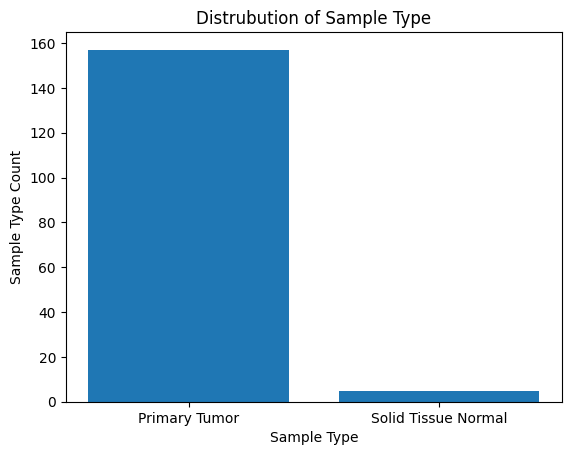

In [4]:
sample_type = file_manifest["sample_type"].value_counts().to_dict()
plt.bar(*zip(*sample_type.items()), align="center")
# Set Title
plt.title("Distrubution of Sample Type")
# Set x-axis label
plt.xlabel("Sample Type")
# Set y-axis label
plt.ylabel("Sample Type Count")

plt.show()

Create framework to properly match file ids, file names, case ids and sample ids into the same data frame to get read counts for each sample.

In [5]:
file_id = file_manifest["file_id"].values
file_names = file_manifest["file_name"].values
case_id = file_manifest["case_id"].values
sample_id = file_manifest["sample_id"].values
sample_type = file_manifest["sample_type"].values
condition = {i: k for i, k in zip(sample_id, sample_type)}

mainfest_elements = zip(file_id, file_names, case_id, sample_id)


manifest_map = {
    id: {
        "file_name": fn,
        "case_id": c_id,
        "sample_id": s_id,
    }
    for id, fn, c_id, s_id in mainfest_elements
}


assay_type = [
    "unstranded",
    "stranded_first",
    "stranded_second",
    "tpm_unstranded",
    "fpkm_unstranded",
    "fpkm_uq_unstranded",
]


assays = {a_type: {s_id: [] for s_id in sample_id} for a_type in assay_type}

The following creates a pickle file of processed RNA-seq data (by assay type), gene ids, and gene names.

In [6]:
path = "data/processedRnaSeq.pickle"
check_file = os.path.isfile(path)

if check_file:
    print("File exsist already, loading now")
    with open("data/processedRnaSeq.pickle", "rb") as f:
        db = pkl.load(f)
else:
    for id in manifest_map:
        file_name = manifest_map[id]["file_name"]
        sample_id = manifest_map[id]["sample_id"]
        partial_data = pd.read_csv(
            f"data\gdc_final\{id}\{file_name}",
            sep="\t",
            header=1,
            skiprows=[2, 3, 4, 5],
        )
        for a_t in assay_type:
            assays[a_t][sample_id] = partial_data[a_t].values.tolist()

    gene_id = partial_data["gene_id"].values.tolist()
    gene_names = partial_data["gene_name"].values.tolist()

    for a_t in assay_type:
        assays[a_t]["gene_id"] = gene_id

    db = {}
    db["assays"] = assays
    db["gene_id"] = gene_id
    db["gene_names"] = gene_names

    with open("data/processedRnaSeq.pickle", "wb") as f:
        pkl.dump(db, f)

assay_data = db["assays"]  # Dictionary of RNA Seq Data

File exsist already, loading now


Create a dataframe with gene ids, gene names, and gene lengths used in the Illumina platforms that completed the RNA sequcencing. 

In [7]:
gene_info = pd.read_csv(
    "data/wgs.ASCAT.gene_level.copy_number_variation.tsv",
    sep="\t",
    header=0,
    usecols=["gene_id", "gene_name", "start", "end"],
)
gene_info["gene_length"] = gene_info.apply(lambda x: x["end"] - x["start"], axis=1)
gene_info.head()

,gene_id,gene_name,start,end,gene_length
0,ENSG00000223972.5,DDX11L1,11869,14409,2540
1,ENSG00000227232.5,WASH7P,14404,29570,15166
2,ENSG00000278267.1,MIR6859-1,17369,17436,67
3,ENSG00000243485.5,MIR1302-2HG,29554,31109,1555
4,ENSG00000284332.1,MIR1302-2,30366,30503,137


#### Assay Choice Rationale
* Stranded_first, refers to data where the first strand of the RNA transcript is kept, preserving the directionality of transcription. This allows you to identify which DNA strand the RNA was transcribed from.
* This is particularly important if you're studying genes that overlap on opposite strands. This however is beyond the scope of this project. 


In [8]:
def get_rna_data(data: dict, assay_type: str) -> pd.DataFrame:
    """
    This function returns desired rna seq count data in a dataframe
    """
    df = pd.DataFrame.from_dict(data[assay_type]).set_index("gene_id")
    return df


count_data = get_rna_data(assay_data, "stranded_first")
count_data.shape
count_data.head()

,TCGA-27-2521-01A,TCGA-19-1390-01A,TCGA-27-1830-01A,TCGA-32-1970-01A,TCGA-06-0190-01A,TCGA-02-2486-01A,TCGA-14-0790-01B,TCGA-14-0789-01A,TCGA-06-0645-01A,TCGA-76-4926-01B,...,TCGA-27-2519-01A,TCGA-26-5134-01A,TCGA-06-0675-11A,TCGA-06-1804-01A,TCGA-14-1829-01A,TCGA-06-0184-01A,TCGA-32-2638-01A,TCGA-12-3652-01A,TCGA-28-5209-01A,TCGA-76-4925-01A
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,174,704,2065,1815,1897,3069,1841,1309,1401,3808,...,2326,387,306,1692,7138,3416,3838,3262,2334,2684
ENSG00000000005.6,17,1,4,13,2,7,5,1,5,33,...,13,3,3,3,66,7,16,1,5,4
ENSG00000000419.13,921,517,544,382,580,718,402,296,652,593,...,764,98,514,604,1109,679,851,865,671,1555
ENSG00000000457.14,504,544,467,383,368,436,292,262,379,548,...,382,137,386,412,492,388,574,267,500,598
ENSG00000000460.17,428,553,377,316,432,298,232,187,322,366,...,282,94,159,310,483,310,407,356,434,549


#### Sample read count Distrubution

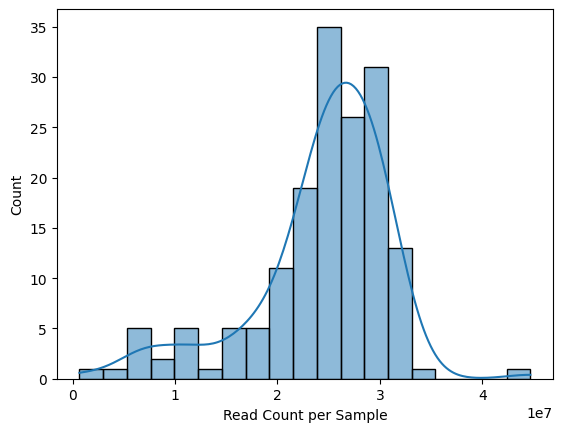

In [9]:
# calcualte total counts per sample and log transform counts
total_counts = count_data.sum(axis=0).to_frame()
total_counts.columns = ["Read Count per Sample"]

log_counts = count_data.apply(lambda x: np.log2(x + 1))

sns.histplot(
    data=total_counts,
    x="Read Count per Sample",
    kde=True,
    # bins=50,
    # bw_adjust=5,
)
plt.show()

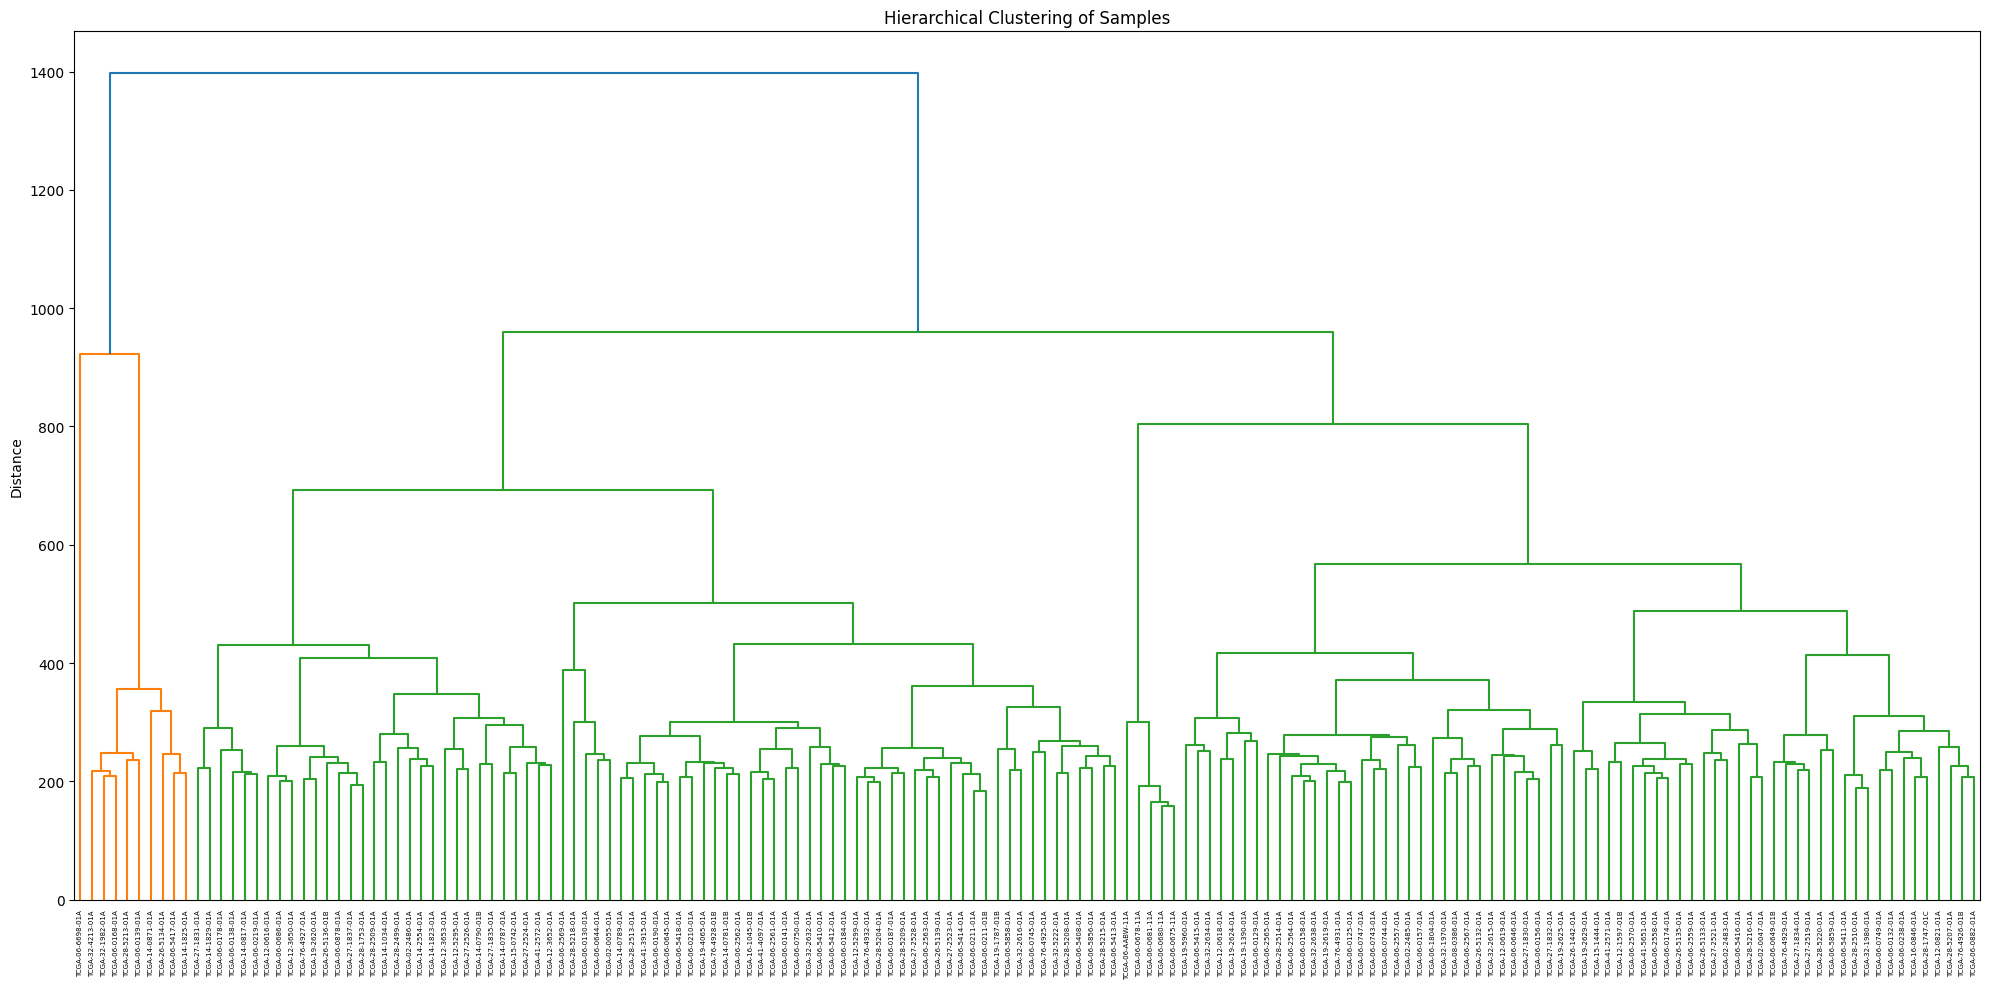

In [10]:
h_clustering = linkage(log_counts.T, "ward")
plt.figure(figsize=(20, 10))
dendrogram(h_clustering, labels=count_data.columns)
plt.xticks(rotation=90)
plt.ylabel("Distance")
plt.title("Hierarchical Clustering of Samples")
plt.tight_layout()
plt.show()

The image above shows the results of hierarchical clustering, which can be visualized via a dendrogram. Samples clustered together are more similar to each other, and the length of the branches (vertical lines) connecting clusters represents the distance or dissimilarity between clusters. The above image shows that the normal tissue samples are more closely related , than the brain tumor samples. 

#### TPM Normalization Method
* TPM normalizes for gene length, but it also ensures that the sum of the TPM values in each sample is the same, making it more comparable across samples. TPM is calculated by normalizing read counts by gene length first, and then scaling by sequencing depth.
* Before applying tpm normalization some genes are missing length information so need to populate using Esmbl API.

In [11]:
gene_map = {gi: gn for gn, gi in zip(db["gene_names"], db["gene_id"])}

gene_length_map = {
    gi: len
    for gi, len in zip(gene_info["gene_id"].values, gene_info["gene_length"].values)
}

gene_to_fix = []
for gene in count_data.index:
    if gene not in gene_length_map:
        gene_to_fix.append(gene)

gene_name = []
for gene in gene_to_fix:
    gene_name.append(gene_map[gene])


def get_gene_name(name):
    server = "https://rest.ensembl.org"
    ext = f"/xrefs/symbol/homo_sapiens/{name}?"

    r = requests.get(server + ext, headers={"Content-Type": "application/json"})

    if not r.ok:
        r.raise_for_status()
        sys.exit()

    stable_gene = r.json()[0]["id"]
    return stable_gene


def get_gene_length(ensmbl):
    server = "https://rest.ensembl.org"
    ext = f"/lookup/id/{ensmbl}?expand=1"

    r = requests.get(server + ext, headers={"Content-Type": "application/json"})

    if not r.ok:
        r.raise_for_status()
        sys.exit()

    length = r.json()["Transcript"][0]["length"]
    # print(repr(decoded))
    return length


fix_genes = {}
for idx, name in enumerate(gene_name):
    stable = get_gene_name(name)
    length = get_gene_length(stable)
    fix_genes[gene_to_fix[idx]] = length
gene_length_map.update(fix_genes)

TPM Normalized read count data.

In [12]:
count_data = count_data[count_data.sum(axis=1) > 0]  # filter out 0 reads
count_data_tpm = count_data.apply(lambda x: x / gene_length_map[x.name], axis=1)
count_data_tpm = count_data_tpm.apply(lambda x: x / (x.sum() / 1_000_000), axis=0)
print(count_data_tpm.shape)
count_data_tpm.head()

(56543, 162)


,TCGA-27-2521-01A,TCGA-19-1390-01A,TCGA-27-1830-01A,TCGA-32-1970-01A,TCGA-06-0190-01A,TCGA-02-2486-01A,TCGA-14-0790-01B,TCGA-14-0789-01A,TCGA-06-0645-01A,TCGA-76-4926-01B,...,TCGA-27-2519-01A,TCGA-26-5134-01A,TCGA-06-0675-11A,TCGA-06-1804-01A,TCGA-14-1829-01A,TCGA-06-0184-01A,TCGA-32-2638-01A,TCGA-12-3652-01A,TCGA-28-5209-01A,TCGA-76-4925-01A
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.362298,11.785398,40.523517,37.115810,43.434346,77.321314,56.744073,34.730010,26.870381,71.147335,...,38.945130,19.850860,4.443098,27.895187,143.514382,51.281836,66.472749,68.244192,54.680790,46.785993
ENSG00000000005.6,0.283101,0.014427,0.067648,0.229103,0.039464,0.151987,0.132813,0.022865,0.082644,0.531350,...,0.187582,0.132616,0.037540,0.042624,1.143583,0.090563,0.238816,0.018030,0.100951,0.060089
ENSG00000000419.13,9.679106,4.707071,5.805967,4.248487,7.222417,9.838194,6.738782,4.271157,6.800986,6.025665,...,6.957055,2.733903,4.058974,5.415698,12.126600,5.543756,8.015984,9.842070,8.549586,14.741862
ENSG00000000457.14,2.810925,2.628465,2.645061,2.260543,2.431899,3.170447,2.597654,2.006311,2.098006,2.955112,...,1.846029,2.028246,1.617646,1.960459,2.855063,1.681160,2.869342,1.612222,3.380926,3.008613
ENSG00000000460.17,0.554730,0.620937,0.496226,0.433431,0.663438,0.503581,0.479629,0.332780,0.414231,0.458663,...,0.316696,0.323405,0.154850,0.342800,0.651353,0.312146,0.472807,0.499554,0.681984,0.641884


#### Quality Control and Filtering
* Filtering out lowly expressed genes across all samples. For more significant differential gene expression analysis. This will help to reduce noise in the data and hopefully focus on relevant genes. Will also improve computing efficiency.

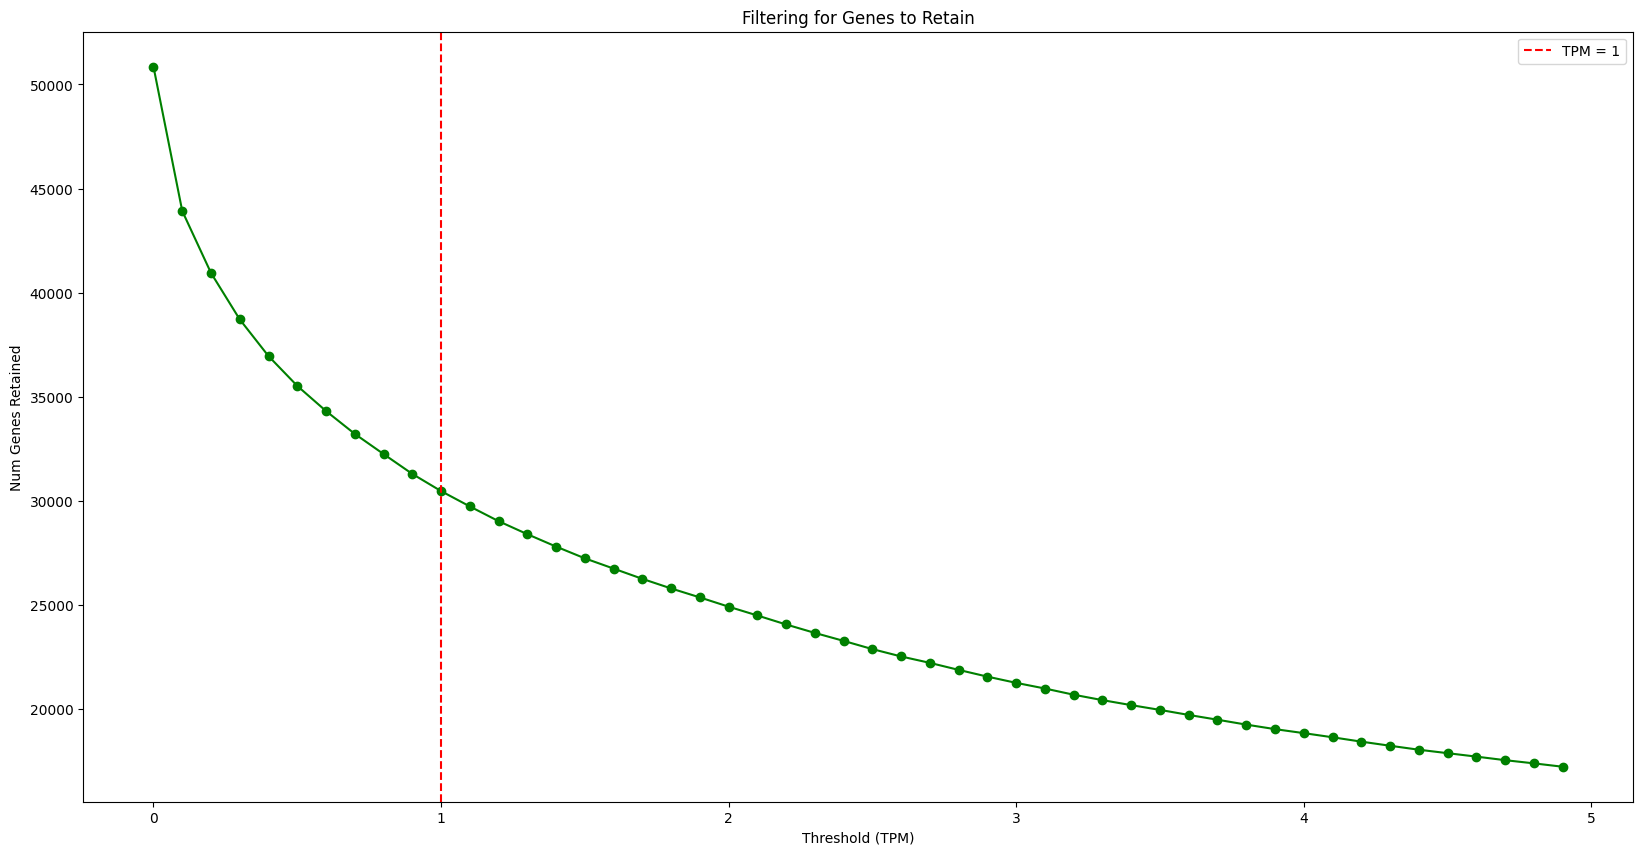

In [13]:
thresholds = np.arange(0, 5, 0.1)
genes_retained = []
for min_tpm in thresholds:
    mask = (count_data_tpm > min_tpm).sum(axis=1) >= 5
    genes_retained.append(mask.sum())  # Count number of genes retained

plt.figure(figsize=(20, 10))
plt.plot(thresholds, genes_retained, marker="o", color="green")
plt.axvline(
    x=1.0, color="red", linestyle="--", label="TPM = 1"
)  # put line at 1 as rough heuristic
plt.xlabel("Threshold (TPM)")
plt.ylabel("Num Genes Retained")
plt.title("Filtering for Genes to Retain")
plt.legend()
plt.show()

Based on chart above i'll filter genes w/ expression threshold of < 1 TPM, 1 TPM threshold is a common heuristic, again the purpose of filtering genes is to increase the statiscal power of the DE analysis. By adding a TPM  filter I'll only consider 30,463 genes out of the original 56,543.


#### Principal Component Analysis of Sample Types

In [14]:
# Separating out the features
x = count_data.loc[:,].T.values

# Separating out the target
metadata = pd.DataFrame(
    zip(count_data.T.index, [condition[x] for x in count_data.T.index]),
    columns=["Sample", "Condition"],
).set_index("Sample")
y = metadata["Condition"].values


x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

finalDf = pd.DataFrame(
    data=principalComponents, columns=["principal component 1", "principal component 2"]
)
finalDf["Target"] = y

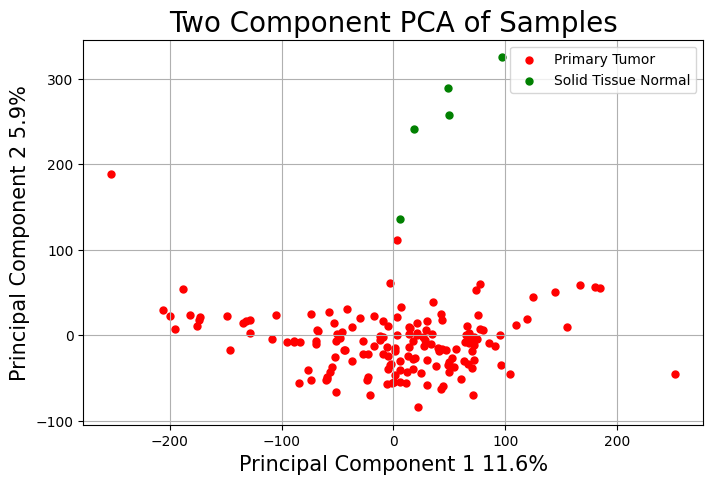

In [15]:
fig = plt.figure(figsize=(8, 5))
pc1 = pca.explained_variance_ratio_[0]
pc2 = pca.explained_variance_ratio_[1]
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(f"Principal Component 1 {pc1*100:.1f}%", fontsize=15)
ax.set_ylabel(f"Principal Component 2 {pc2*100:.1f}%", fontsize=15)
ax.set_title("Two Component PCA of Samples", fontsize=20)

targets = ["Primary Tumor", "Solid Tissue Normal"]
colors = ["r", "g"]
for target, color in zip(targets, colors):
    indicesToKeep = finalDf["Target"] == target
    ax.scatter(
        finalDf.loc[indicesToKeep, "principal component 1"],
        finalDf.loc[indicesToKeep, "principal component 2"],
        c=color,
        s=25,
    )
ax.grid()
ax.legend(targets)

* The Principal Component Graph (PCA) graph shown above is the result of two-component analysis showing the two sample groups being study. The first principal component captures the most variablity 11.6% and the second component captures 5.9%. Take note I used the raw count data to create pca plot. Using TPM normalized counts would change the amount of variance explain by each component. Filtering the genes would also alter the variance as well. 
* The plot visualizes the relationship between the samples based on their pc scores. You can the seperation between the two sample groups and potential clustering within samples that are more similar to one another. There also looks like their may be some outliers in the two sample groups as there are samples that seem to be away from clusters.

#### Differential Expression Analysis

In [16]:
mask = (count_data_tpm > 1).sum(axis=1) >= 5  # filtering huerstic
filtered_data = count_data_tpm[mask]
print(filtered_data.shape)

normal_sample = metadata.index[metadata["Condition"] == "Solid Tissue Normal"]
tumor_sample = metadata.index[metadata["Condition"] == "Primary Tumor"]
results = []

for gene in filtered_data.index:
    base_mean = filtered_data.loc[gene, :].mean()
    normal = filtered_data.loc[gene, normal_sample]
    tumor = filtered_data.loc[gene, tumor_sample]
    normal_mean = normal.mean()
    tumor_mean = tumor.mean()
    fc = (tumor_mean - normal_mean) / normal_mean  # fold change
    log2fc = np.log2((tumor_mean + 1) / (normal_mean + 1))  # Adding 1 to avoid log of 0
    t_stat, p_val = ttest_ind(normal, tumor)
    results.append(
        {
            "geneid": gene,
            "fc": fc,
            "base_mean": base_mean,
            "log2fc": log2fc,
            "t_stat": t_stat,
            "p_val": p_val,
        }
    )
# filtered_data.head()

(30463, 162)


C:\Users\osuch\AppData\Local\Temp\ipykernel_12912\244121798.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  fc = (tumor_mean - normal_mean) / normal_mean  # fold change


Final filtering for signficant genes. Another heurstic I'll be using is eleminating genes with a base mean less than 10 also I will filter for adusted pvalues < 0.05 and absolute log2 fold changes > 1.

In [17]:
results_df = pd.DataFrame(results)
results_df["padj"] = multipletests(results_df["p_val"], method="fdr_bh")[1]
results_df["abs_log2fc"] = results_df["log2fc"].abs()
results_df["symbol"] = results_df.apply(lambda row: gene_map[row["geneid"]], axis=1)

results = results_df[results_df.base_mean >= 10]
sigs = results[(results.padj < 0.05) & (abs(results.log2fc) > 1)]
print(
    f"After running differential gene expression analysis and filtering for significant genes based on the above criteria we are left with {len(sigs)} genes"
)
sigs.head()

After running differential gene expression analysis and filtering for significant genes based on the above criteria we are left with 2092 genes


,geneid,fc,base_mean,log2fc,t_stat,p_val,padj,abs_log2fc,symbol
0,ENSG00000000003.15,9.739217,45.924452,3.159546,-3.759455,0.000238,0.002085,3.159546,TSPAN6
6,ENSG00000001036.14,1.784385,21.818367,1.370717,-3.319123,0.001118,0.007373,1.370717,FUCA2
19,ENSG00000002549.12,2.311172,34.013409,1.636995,-3.286768,0.001246,0.008065,1.636995,LAP3
20,ENSG00000002586.20,11.054143,75.951787,3.402884,-4.047245,0.000080,0.000842,3.402884,CD99
43,ENSG00000004455.17,3.132240,11.604690,1.732940,-5.006171,0.000001,0.000022,1.732940,AK2


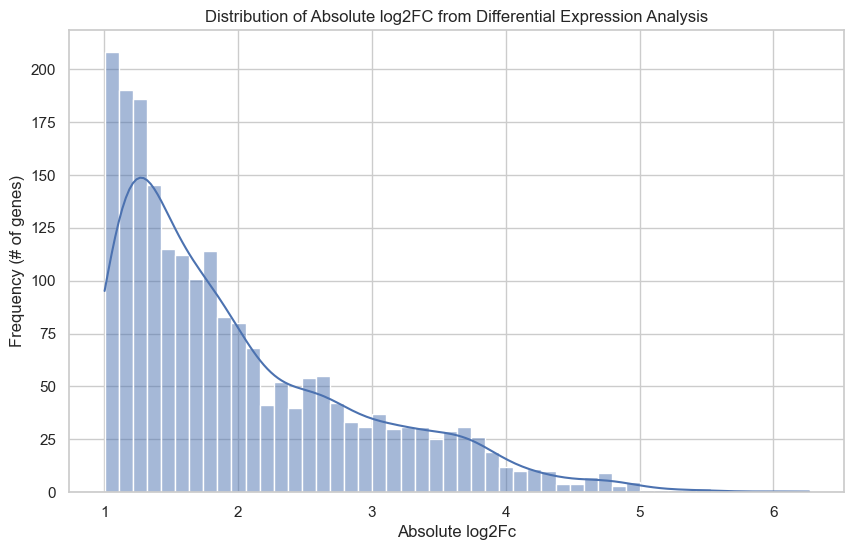

In [18]:
# view distribution of scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(sigs["abs_log2fc"], bins=50, kde=True)
plt.title("Distribution of Absolute log2FC from Differential Expression Analysis")
plt.xlabel("Absolute log2Fc")
plt.ylabel("Frequency (# of genes)")
plt.show()

The distribution graph displays the absolute log2 fold change (log2FC) values, which measure the magnitude of gene expression changes between tumor and normal samples. Most genes fall within the lower range of absolute log2FC (0.5 to 1.5), indicating relatively small expression changes. The highest frequency of genes has a log2FC value around 1, reflecting a roughly 2-fold expression change. As log2FC increases, the frequency of genes decreases, showing that large changes in expression (log2FC > 2) are less common. The graph follows a right-skewed distribution, with a long tail suggesting that while small fold changes are typical, some genes still exhibit substantial expression changes (log2FC > 4), albeit less frequently.

### Volcano Plots of DE genes

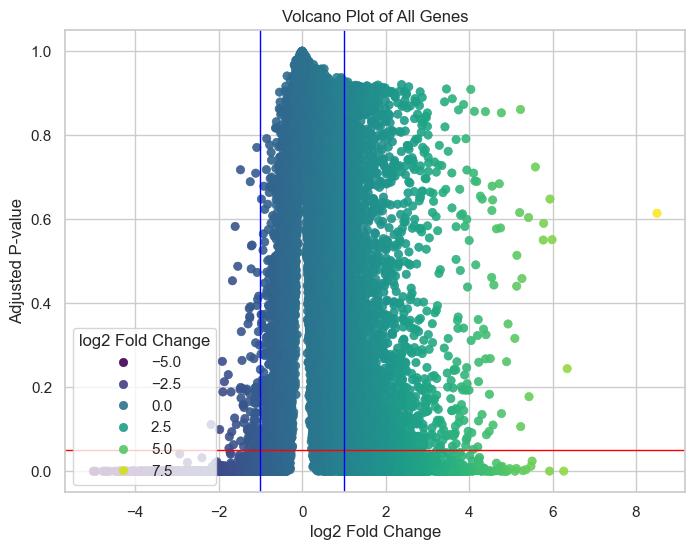

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=results_df,
    x="log2fc",
    y="padj",
    hue="log2fc",
    palette="viridis",
    alpha=0.9,
    edgecolor=None,
)
plt.title("Volcano Plot of All Genes")
plt.axhline(y=0.05, color="red", linestyle="-", linewidth=1)
plt.axvline(x=1, color="blue", linestyle="-", linewidth=1)
plt.axvline(x=-1, color="blue", linestyle="-", linewidth=1)
plt.xlabel("log2 Fold Change")
plt.ylabel("Adjusted P-value")
plt.legend(title="log2 Fold Change", loc="lower left")
plt.show()

The volcano plot displays the log2 fold change (x-axis) to show gene expression differences between tumor and normal samples, with positive values indicating upregulation in tumors and negative values indicating downregulation. The y-axis represents the adjusted p-value, where lower values indicate higher statistical significance, and a red line marks the significance cutoff. Genes with larger fold changes are highlighted in brighter colors (yellow/green for upregulated, blue/purple for downregulated). Vertical blue lines denote fold change thresholds, indicating biologically significant changes. Genes on the far right upregulated and genes to the far left are downregulated, while those near the center exhibit little to no differential expression.

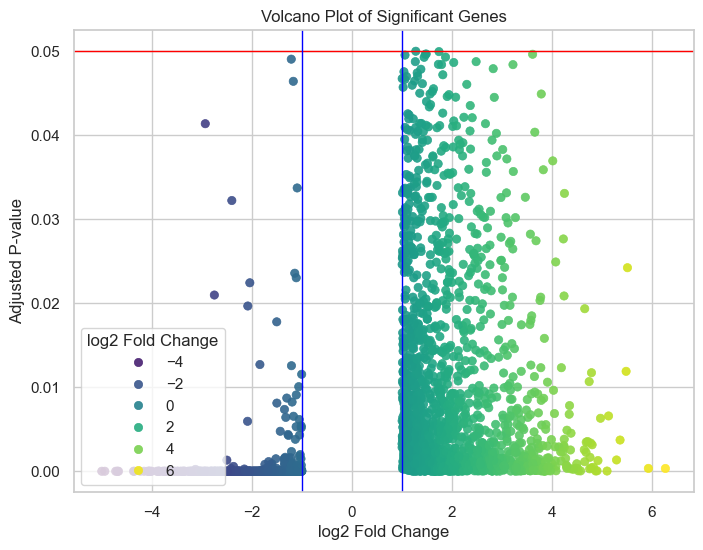

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=sigs,
    x="log2fc",
    y="padj",
    hue="log2fc",
    palette="viridis",
    alpha=0.9,
    edgecolor=None,
)
plt.title("Volcano Plot of Significant Genes")
plt.axhline(y=0.05, color="red", linestyle="-", linewidth=1)
plt.axvline(x=1, color="blue", linestyle="-", linewidth=1)
plt.axvline(x=-1, color="blue", linestyle="-", linewidth=1)
plt.xlabel("log2 Fold Change")
plt.ylabel("Adjusted P-value")
plt.legend(title="log2 Fold Change", loc="lower left")
plt.show()

This volcano plot focuses on significant genes and provides a clearer view of the genes with both substantial fold changes and strong statistical significance. There appears to be a stronger pattern of upregulation in tumor samples compared to downregulation, with fewer downregulated genes meeting the significance threshold. 

In [21]:
# Extract the list of gene names for DEGs

gene_list = sigs[sigs["abs_log2fc"] >= 2].symbol.tolist()

# Initialize g:Profiler
gpro = GProfiler(return_dataframe=True)

# Perform GO analysis using the significant gene list
go_results = gpro.profile(organism="hsapiens", query=gene_list)

# Display the first few results
go_results.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0030054,cell junction,1.248963e-27,True,"""A cellular component that forms a specialized...",2230,385,119,22097,0.309091,0.053363,query_1,[GO:0110165]
1,GO:CC,GO:0031982,vesicle,3.023965e-24,True,"""Any small, fluid-filled, spherical organelle ...",4004,385,159,22097,0.412987,0.039710,query_1,[GO:0043227]
2,GO:CC,GO:0045202,synapse,2.348335e-23,True,"""The junction between an axon of one neuron an...",1468,385,89,22097,0.231169,0.060627,query_1,[GO:0030054]
3,GO:CC,GO:0005737,cytoplasm,6.472974e-18,True,"""The contents of a cell excluding the plasma m...",12345,385,301,22097,0.781818,0.024382,query_1,"[GO:0005622, GO:0110165]"
4,GO:CC,GO:0022626,cytosolic ribosome,1.099537e-16,True,"""A ribosome located in the cytosol."" [GOC:mtg_...",117,385,24,22097,0.062338,0.205128,query_1,"[GO:0005829, GO:0005840]"


In [22]:
# perform pathway analysis
pathway_analysis_results = gpro.profile(
    organism="hsapiens", query=gene_list, sources=["KEGG", "REAC"]
)
# display the results
pathway_analysis_results.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,REAC,REAC:R-HSA-156842,Eukaryotic Translation Elongation,1.668325e-16,True,Eukaryotic Translation Elongation,94,245,24,10842,0.097959,0.255319,query_1,[REAC:R-HSA-72766]
1,REAC,REAC:R-HSA-156902,Peptide chain elongation,9.262719e-16,True,Peptide chain elongation,90,245,23,10842,0.093878,0.255556,query_1,[REAC:R-HSA-156842]
2,REAC,REAC:R-HSA-192823,Viral mRNA Translation,1.485265e-14,True,Viral mRNA Translation,90,245,22,10842,0.089796,0.244444,query_1,[REAC:R-HSA-168273]
3,REAC,REAC:R-HSA-1799339,SRP-dependent cotranslational protein targetin...,1.702170e-14,True,SRP-dependent cotranslational protein targetin...,113,245,24,10842,0.097959,0.212389,query_1,[REAC:R-HSA-72766]
4,REAC,REAC:R-HSA-2408557,Selenocysteine synthesis,4.064438e-14,True,Selenocysteine synthesis,94,245,22,10842,0.089796,0.234043,query_1,[REAC:R-HSA-2408522]


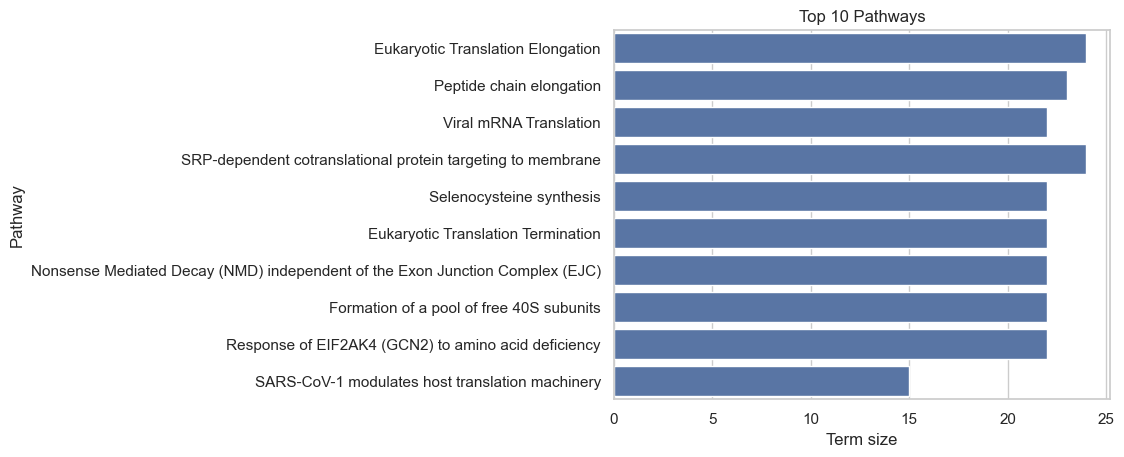

In [23]:
sns.barplot(x="intersection_size", y="name", data=pathway_analysis_results.head(10))
plt.title("Top 10 Pathways")
plt.xlabel("Term size")
plt.ylabel("Pathway")
plt.show()

The Gene Ontology (GO) enrichment analysis chart you provided highlights pathways enriched in your dataset, likely from the genes identified as differentially expressed in GBM compared to normal tissue. Here’s an interpretation of the key pathways in relation to Glioblastoma Multiforme (GBM):

1. Eukaryotic Translation Elongation and Peptide Chain Elongation
These pathways are involved in protein synthesis, specifically in elongating the amino acid chain during translation. Overactivation of translation processes is common in cancers, including GBM, where rapid cell growth and division demand increased protein synthesis.

2. Viral mRNA Translation and Host Translation Machinery Modulation
Cancer cells, similar to viral infections, often hijack the host's translational machinery for their own growth. GBM cells may exploit these pathways to support uncontrolled proliferation. Interestingly, the presence of pathways associated with viral translation highlights how tumor cells might mimic viral strategies for survival and growth.

3. SRP-Dependent Cotranslational Protein Targeting to Membrane
This pathway is involved in targeting proteins to the endoplasmic reticulum membrane, a critical process for producing membrane-bound and secretory proteins. In GBM, these processes could facilitate cell signaling changes and tumor growth, as many oncogenic proteins are membrane-associated.

4. Selenocysteine Synthesis
Selenoproteins play a role in redox regulation and oxidative stress. Cancer cells, including GBM cells, often manipulate oxidative stress pathways to promote survival and resistance to treatments.

5. Nonsense-Mediated Decay (NMD)
NMD is a quality control pathway that degrades mRNA with premature stop codons, preventing translation of potentially harmful truncated proteins. In cancer, alterations in NMD can affect gene expression stability, leading to the dysregulation of genes involved in cell growth and survival.

6. Response to Amino Acid Deficiency (EIF2AK4/GCN2)
Cancer cells frequently experience metabolic stress, including nutrient deprivation. GBM cells may upregulate pathways that allow them to survive under amino acid deprivation, supporting their adaptation to the tumor microenvironment.

These enriched pathways suggest that GBM tumors may depend heavily on translational and metabolic regulation to support tumor growth and survival. The findings indicate potential targets for therapy, such as inhibitors of protein synthesis pathways or regulators of oxidative stress. These pathways could also inform biomarkers for GBM, especially in distinguishing GBM cells' adaptations compared to normal brain tissue.

In [24]:
ranking = sigs[["symbol", "t_stat"]].dropna().sort_values("t_stat", ascending=False)
manual_set = {"things": sigs.symbol}


pre_res = gp.prerank(
    rnk=ranking,
    gene_sets=["GO_Biological_Process_2021", manual_set],
    seed=6,
    permutation_num=100,
)

In [25]:
out = []
for term in list(pre_res.results):
    out.append(
        [
            term,
            pre_res.results[term]["fdr"],
            pre_res.results[term]["es"],
            pre_res.results[term]["nes"],
        ]
    )
out_df = (
    pd.DataFrame(out, columns=["Term", "fdr", "es", "nes"])
    .sort_values("fdr")
    .reset_index(drop=True)
)
out_df

,Term,fdr,es,nes
0,GO_Biological_Process_2021__protein targeting ...,0.0,-0.273625,-2.138840
1,GO_Biological_Process_2021__mRNA processing (G...,0.0,-0.356528,-2.219854
2,"GO_Biological_Process_2021__RNA splicing, via ...",0.0,-0.383762,-2.336474
3,"GO_Biological_Process_2021__mRNA splicing, via...",0.0,-0.361982,-2.202237
4,GO_Biological_Process_2021__protein N-linked g...,0.0,-0.493344,-2.341351
...,...,...,...,...
268,GO_Biological_Process_2021__mitochondrion orga...,1.0,0.217855,0.699544
269,GO_Biological_Process_2021__regulation of phos...,1.0,0.172608,0.576438
270,GO_Biological_Process_2021__receptor-mediated ...,1.0,0.254994,0.764255
271,GO_Biological_Process_2021__DNA repair (GO:000...,1.0,0.147265,0.532827


### Gene Set Enrichment Analysis Example

[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

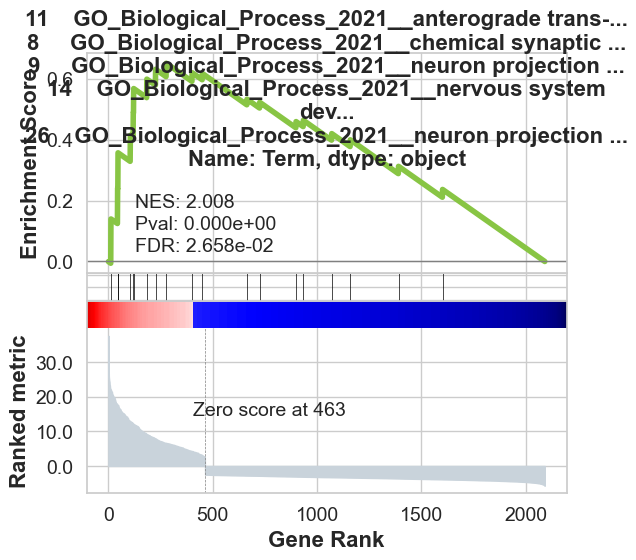

In [26]:
gseaplot(
    rank_metric=pre_res.ranking,
    term=out_df.sort_values("nes", ascending=False).iloc[:5].Term,
    **pre_res.results[out_df.sort_values("nes", ascending=False).iloc[5].Term]
)

### Conclusion 
The analysis identified several genes with significant differential expression in GBM versus normal tissue. The upregulated genes may play roles in tumor growth, invasion, and resistance to therapy, while downregulated genes could be associated with disrupted normal cell function in the tumor environment. These findings provide a foundation for further investigation into the molecular mechanisms of GBM and may guide the development of targeted therapies or biomarkers for early detection and treatment monitoring.

Future Directions This analysis has identified several promising avenues for further research. Investigating specific genes within these enriched pathways could provide insights into their precise roles in GBM pathology. Additionally, experimental studies validating the effects of inhibiting key pathways—such as translation, cellular communication, and metabolic stress response—would help assess their therapeutic potential. Further analysis on patient outcomes associated with these gene signatures could also refine biomarker discovery for prognosis and treatment response in GBM.